In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import seaborn as sns

In [254]:
# Import csv file raw data
raw_df = pd.read_csv('../data/earthquakes.csv')

 Appalachian Basin Region Earthquake Data

Here we will be looking at the earthquake event data for the Appalachian Basin Region from the year 1973 to 2015.  This data encompases information from Quebec, Canada to Kentucky.


In [255]:
# First look at DataFrame head
raw_df.head()

,_EventID_,_Latitude_,_Longitude_,_DepthMeters_,_Contributor_,_MagType_,_Magnitude_,_EventLocationName_,_Time_,ts,potential_blast,bix_potential_blasts
0,usp000gyu4,39.644,-75.483,5000,NEIC,md,2.8,New Jersey,2009-07-01T13:44:43.380Z,2009/07/01 09:44:43-04,0,0
1,usp000gyxs,37.379,-80.746,11500,NEIC,mblg,2.8,West Virginia,2009-07-04T12:24:43.460Z,2009/07/04 08:24:43-04,0,0
2,usp000gz1d,45.296,-73.475,18000,NEIC,md,2.1,"southern Quebec, Canada",2009-07-08T10:22:11.430Z,2009/07/08 06:22:11-04,0,0
3,usp000h1sz,42.825,-78.239,5000,NEIC,md,2.4,New York,2009-09-23T03:45:59.900Z,2009/09/22 23:45:59-04,0,0
4,usp000hab0,38.619,-80.909,100,NEIC,mblg,3.4,West Virginia,2010-04-04T09:19:14.000Z,2010/04/04 05:19:14-04,0,0


In [256]:
# DataFrame shape
raw_df.shape

(1647, 12)

For this data set there are 1,647 instances of earthquakes (natural and potential blast impact).

In [257]:
# List of DataFrame column names
raw_df.columns

Index(['_EventID_', '_Latitude_', '_Longitude_', '_DepthMeters_',
       '_Contributor_', '_MagType_', '_Magnitude_', '_EventLocationName_',
       '_Time_', 'ts', 'potential_blast', 'bix_potential_blasts'],
      dtype='object')

In [258]:
# Rename columns
raw_df.rename(columns = {
    '_EventID_' : 'event_id',
    '_Latitude_' : 'latitude',
    '_Longitude_' : 'longitude',
    '_DepthMeters_' : 'depth',
    '_Contributor_' : 'contributor',
    '_MagType_' : 'mag_type',
    '_Magnitude_' : 'magnitude',
    '_EventLocationName_' : 'state',
    '_Time_' : 'time',
    'ts' : 'time_series'
}, inplace=True)

We have plenty of information to investigate.  The information gives us the Event ID for each earthquake event, it's global location, it's depth, which national earthquake service recorded the earthquake, wave length types, and it's magnitude scale, date/time, and if the earthquake was a natural event or a potentially manmade blast that registered a wave length detected at one of the research centers.

Naturally occuring events are noted by a '0' under the Potential Blast column.  If the event is a man made seismic event it will be noted with a '1'.

The two centers that contributed information to this data set are the Array Network Facility (ANF) and the National Earthquake Information Center (NEIC)

There is also more specific location information such as state and distance from certain cities, however, that information is not available to all instances.

In [259]:
# DataFrame info
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1647 entries, 0 to 1646
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   event_id              1647 non-null   object 
 1   latitude              1647 non-null   float64
 2   longitude             1647 non-null   float64
 3   depth                 1647 non-null   int64  
 4   contributor           1647 non-null   object 
 5   mag_type              1628 non-null   object 
 6   magnitude             1647 non-null   float64
 7   state                 1647 non-null   object 
 8   time                  1647 non-null   object 
 9   time_series           1647 non-null   object 
 10  potential_blast       1647 non-null   int64  
 11  bix_potential_blasts  1647 non-null   int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 154.5+ KB


In [260]:
# Identify missing values
raw_df.isnull().sum()

event_id                 0
latitude                 0
longitude                0
depth                    0
contributor              0
mag_type                19
magnitude                0
state                    0
time                     0
time_series              0
potential_blast          0
bix_potential_blasts     0
dtype: int64

In [261]:
# Function to resolve null values with 'Unknown' text

def Resolve_null_values(raw_df: pd.DataFrame) -> pd.DataFrame:
    """
    This function resolves null values and replaces them with 'Unknown' text.  This is identifying a specific column for replacement 'mag_type'
    Args: 
    raw_df: This is the data frame to resolve the null values within the specific column 'mag_type'.
    Return:
    This returns the data frame with the updated resolved null values replaced with the text 'Unknown'.
    """
    # Fill missing values with "Unknown"
    updated_null_df = raw_df.copy()
    raw_df. fillna({'mag_type': 'Unknown'}, inplace=True)
    
    return updated_null_df

Applying function to resolve null values.

In [262]:
updated_null_df = Resolve_null_values(raw_df)

There is missing information for the Magnitude Type column, however, we will not be using the information for this analysis, so the column will be omitted.

In [263]:
# Identify datatypes
updated_null_df.dtypes

event_id                 object
latitude                float64
longitude               float64
depth                     int64
contributor              object
mag_type                 object
magnitude               float64
state                    object
time                     object
time_series              object
potential_blast           int64
bix_potential_blasts      int64
dtype: object

In [264]:
# Function to fix time format and reorder columns, following prior function replaced raw_df with updated_null_df
def Fix_time_format(updated_null_df: pd.DataFrame) -> pd.DataFrame:
    """
    This function fixes the time and datetime types, adds new columns to the data frame, 
    and moves those columns to the front of the dataframe.
    Args: 
    updated_null_df(for this specific usage): This is the data frame to fix the datetimes.  Minor correction to function to resolve a mixed time format issue.
    Return:
    This returns the data frame with the updated datetime values, adds new columns to the data frame, 
    and moves those columns to the front of the data frame.
    """
    if 'time' not in updated_null_df.columns:
        raise KeyError("Input DataFrame must contain a 'time' column.")
    updated_time_df = updated_null_df.copy()
 
# Update columns to datetime and split into time, date, month, and year
    updated_time_df['time'] = pd.to_datetime(updated_time_df['time'], format='mixed', utc=True)
    updated_time_df['date'] = updated_time_df['time'].dt.date
    updated_time_df['time'] = updated_time_df['time'].dt.time
    updated_time_df['date'] = pd.to_datetime(updated_time_df['date'])
    updated_time_df['month'] = updated_time_df['date'].dt.month
    updated_time_df['year'] = updated_time_df['date'].dt.year

# Move columns to the front of the column list
    column_to_move1 = updated_time_df.pop('date')
    updated_time_df.insert(1, 'date', column_to_move1)

    column_to_move2 = updated_time_df.pop('month')
    updated_time_df.insert(2, 'month', column_to_move2)

    column_to_move3 = updated_time_df.pop('year')
    updated_time_df.insert(2, 'year', column_to_move3)

    return updated_time_df

Applying function to resolve datetime, split date to month and year, and move coloumns to the front of the column list.

In [265]:
updated_time_df = Fix_time_format(updated_null_df) 

In [266]:
earthquake_df = updated_time_df.copy()

In [288]:
# Correction from int32 to int64
earthquake_df["year"] = earthquake_df["year"].astype("int64")
earthquake_df["month"] = earthquake_df["month"].astype("int64")

In [287]:
earthquake_df.dtypes

event_id                        object
date                    datetime64[ns]
year                             int64
month                            int64
latitude                       float64
longitude                      float64
depth                            int64
mag_type                        object
magnitude                      float64
state                           object
time                            object
potential_blast                  int64
bix_potential_blasts             int64
dtype: object

The average depth for a seismic event in the Appalachian Basin Region is 7,561 meters with an average magnitue of 2.3.

The majority of seismic events for this data set occured in 2013.

In [268]:
# Value counts for categories
locations = earthquake_df['state'].value_counts()
pd.set_option('display.max_rows', None)
print(locations)

state
WEST VIRGINIA                                   842
NEW YORK                                        189
PENNSYLVANIA                                    172
New York                                        119
Pennsylvania                                     55
West Virginia                                    23
VIRGINIA                                         22
Ontario-Quebec border region, Canada             16
Ohio                                             14
New Jersey                                       12
Greater New York area, New Jersey                11
NEW JERSEY                                       10
SOUTHERN QUEBEC, CANADA                          10
OHIO                                              9
southern Quebec, Canada                           8
CHESAPEAKE BAY REGION                             7
Greater Philadelphia area, New Jersey             6
Youngstown-Akron urban area, Ohio                 6
Virginia                                          4
Greate

To sort the information better the seismic events are grouped into states/regions where they occured.

In [269]:
# Complile locations into states

# New Jersey
pattern_1 = '|'.join(["New Jersey", "NEW JERSEY","Greater New York area, New Jersey","Greater Philadelphia area, New Jersey",
    "1km SSW of Clifton, New Jersey", "5km N of Boonton, New Jersey", "3km WSW of Jersey City, New Jersey","0km SW of Lindenwold, New Jersey",
    "1km NNE of Hillsdale, New Jersey","1km N of Wanaque, New Jersey","2km WNW of Fairfield, New Jersey","8km W of Vista Center, New Jersey",
    "4km SW of Ringwood, New Jersey"
    ])
earthquake_df['state'] = earthquake_df['state'].str.replace(pattern_1, 'New Jersey', regex=True)

# New York
pattern_2 = '|'.join(["New York", "NEW YORK", "41km S of Lake Placid, New York", "5km SSE of Attica, New York",
    "45km NW of Warrensburg, New York", "21km NNE of Medina, New York","18km WNW of Malone, New York", "15km SW of Altamont, New York",
    "42km NNE of Lake Pleasant, New York", "9km NE of Dundee, New York", "9km NNW of Brownville, New York", "5km NE of Hadley, New York",
    "7km ENE of Massena, New York", "5km SE of Canton, New York", "18km NW of Champlain, New York","9km WNW of Dannemora, New York",
    "26km SE of Malone, New York", "4km W of Altamont, New York","19km N of Alexandria Bay, New York","2km S of Heritage Hills, New York",
    "7km NE of Massena, New York","9km NNE of Medina, New York","21km NW of Warrensburg, New York","6km W of South Lockport, New York",
    "27km NNE of Olcott, New York","7km NNW of Brownville, New York","19km NNW of Youngstown, New York","35km E of Carthage, New York",
    "16km WSW of Peru, New York","8km ENE of Broadalbin, New York","1km ESE of Norwood, New York","25km NNE of Utica, New York",
    "2km ESE of Highland Falls, New York", "4km WSW of Fonda, New York","15km NW of Hadley, New York","32km NW of Warrensburg, New York",
    "39km SE of Tupper Lake, New York","7km SE of Dannemora, New York","12km NNW of Tupper Lake, New York","27km ENE of Carthage, New York",
    "25km N of Olcott, New York","9km NE of Medina, New York","13km W of Norwood, New York","5km S of Lake Erie Beach, New York",
    "21km SSE of Hannawa Falls, New York","1km SW of Rye Brook, New York","11km W of Dannemora, New York","31km NW of Warrensburg, New York",
    "24km WSW of Malone, New York"
    ])
earthquake_df['state'] = earthquake_df['state'].str.replace(pattern_2, 'New York', regex=True)

# West Virginia
pattern_3 = '|'.join(["West Virginia", "WEST VIRGINIA", "13km SW of Glenville, West Virginia", "12km SSW of Glenville, West Virginia",
    "2km N of Alderson, West Virginia", "14km SW of Glenville, West Virginia","13km NNE of Sissonville, West Virginia",
    "11km WSW of Sutton, West Virginia","10km WNW of Sutton, West Virginia","Potomac-Shenandoah region" 
    ])
earthquake_df['state'] = earthquake_df['state'].str.replace(pattern_3, 'West Virginia', regex=True)

# Pennsylvania
pattern_4 = '|'.join(["PENNSYLVANIA", "Pennsylvania", "Greater Philadelphia area, Pennsylvania", "2km SE of Guilford Siding, Pennsylvania",
    "1km SSW of Garden View, Pennsylvania", "8km NNE of Greenville, Pennsylvania","2km SE of Conestoga, Pennsylvania",
    "3km WSW of Exton, Pennsylvania","11km NNW of Susquehanna Trails, Pennsylvania"                 
    ])
earthquake_df['state'] = earthquake_df['state'].str.replace(pattern_4, 'Pennsylvania', regex=True)

# Virginia
pattern_5 = '|'.join(["VIRGINIA", "Virginia","11km E of Bland, Virginia"])
earthquake_df['state'] = earthquake_df['state'].str.replace(pattern_5, 'Virginia', regex=True)

# Ohio
pattern_6 = '|'.join(["Ohio ", "OHIO", "Lake Erie, Ohio", "Youngstown-Akron urban area, Ohio", "2km S of Lowellville, Ohio", 
    "15km S of Gallipolis, Ohio", "3km SSW of Lowellville, Ohio", "3km S of Lowellville, Ohio","1km WSW of Bolindale, Ohio",
    "2km SSW of Lowellville, Ohio"
    ])
earthquake_df['state'] = earthquake_df['state'].str.replace(pattern_6, 'Ohio', regex=True)

# Quebec
pattern_7 = '|'.join(["Ontario-Quebec border region, Canada","SOUTHERN QUEBEC, CANADA", "southern Quebec, Canada", "10km ESE of Cornwall, Canada",
    "3km WNW of Huntingdon, Canada","39km SSW of Cobourg, Canada","29km SE of Toronto, Canada","3km SSW of Huntingdon, Canada",
    "6km NNE of Ormstown, Canada","8km SSW of Salaberry-de-Valleyfield, Canada","6km SW of Salaberry-de-Valleyfield, Canada",
    "southern Ontario, Canada","11km S of Sainte-Martine, Canada","4km SW of Huntingdon, Canada","9km E of Ormstown, Canada",
    "8km SSW of Huntingdon, Canada","8km NNW of Huntingdon, Canada","1km W of Ormstown, Canada"
    ])
earthquake_df['state'] = earthquake_df['state'].str.replace(pattern_7, 'Quebec', regex=True)

# Kentucky
pattern_8 = '|'.join(["eastern Kentucky","7km WSW of Flatwoods, Kentucky","8km S of Greenup, Kentucky"])
earthquake_df['state'] = earthquake_df['state'].str.replace(pattern_8, 'Kentucky', regex=True)

# Connecticut
pattern_9 = '|'.join(["0km SE of Byram, Connecticut"])
earthquake_df['state'] = earthquake_df['state'].str.replace(pattern_9, 'Connecticut', regex=True)

# Delaware
pattern_10 = '|'.join(["Wilmington urban area, Delaware"])
earthquake_df['state'] = earthquake_df['state'].str.replace(pattern_10, 'Delaware', regex=True)

# Maryland
pattern_11 = '|'.join(["CHESAPEAKE BAY REGION","Chesapeake Bay region"])
earthquake_df['state'] = earthquake_df['state'].str.replace(pattern_11, 'Maryland', regex=True)

This now gives a more understandable count of events for each state.

In [270]:
# Updated location totals
locations = earthquake_df['state'].value_counts()
pd.set_option('display.max_rows', None)
print(locations)

state
West Virginia    874
New York         355
Pennsylvania     237
New Jersey        49
Quebec            49
Ohio              38
Virginia          27
Maryland           9
Kentucky           4
Vermont            3
Connecticut        1
Delaware           1
Name: count, dtype: int64


In [271]:
# Drop Contributor column
earthquake_df.drop('contributor', axis=1, inplace=True)

#Drop Time Series
earthquake_df.drop('time_series',axis=1, inplace=True)



In [272]:
earthquake_df.to_csv('../data/applachian_quakes.csv')

### Visualizations
---

This plot shows a heat map of the statistical information.  There is a strong correlation between Latitude and Longitude because all of the seismic events are in the Appalachian Basin Region.

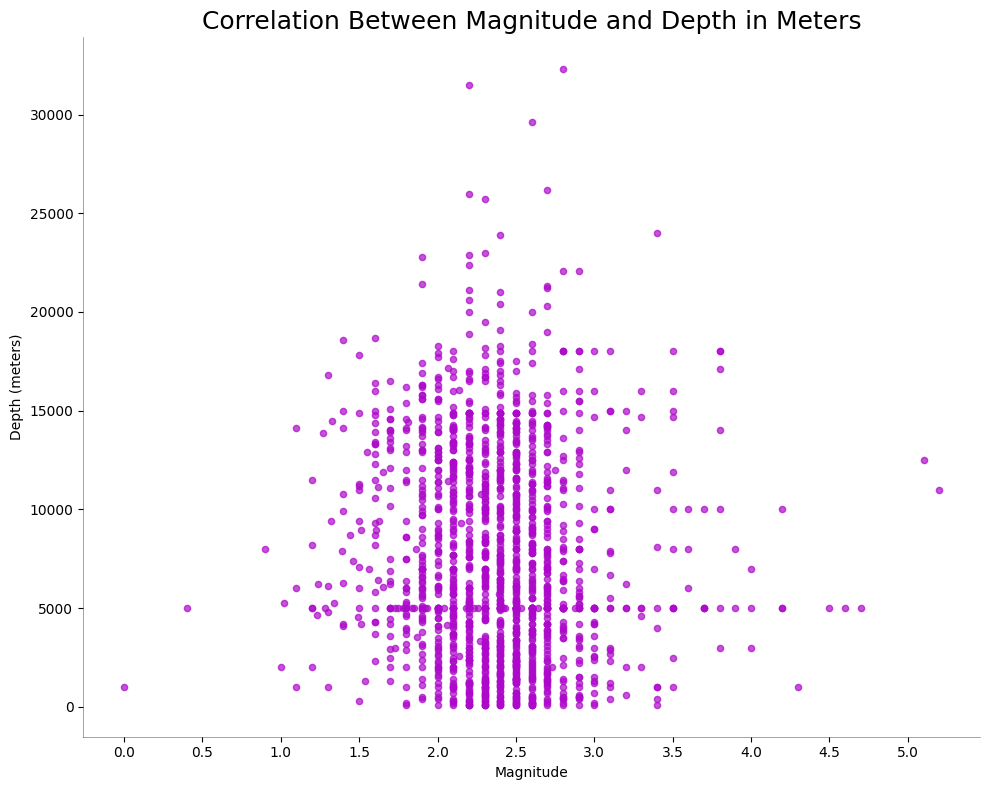

In [273]:
# Correlation Between Magnitude and Depth in Meters

plt.figure(figsize=(10,8))

plt.scatter(
    earthquake_df['magnitude'],
    earthquake_df['depth'],
    color = "#ad09ca",
    alpha = 0.7,
    s = 20
)

plt.xlabel('Magnitude')
plt.ylabel('Depth (meters)')

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
    spine.set_alpha(0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Correlation Between Magnitude and Depth in Meters', fontsize=18)

ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.xaxis.set_major_formatter('{x:.1f}')      
ax.xaxis.set_minor_locator(MultipleLocator(5))
 
plt.tight_layout()
plt.savefig('../plots/CorrelationBetweenMagnitudeAndDepthInMeters_AppalachianRegion')
plt.show()


This plot shows most seismic events fall between a magnitude of 1.9 and 2.7 and are less than 15,000 meters deep.

I chose this color to stay with the cool purple theme.  I chose the scatter plot to see if Depth and Magnitude had any similarties and it did show a trend as well as outliers.

In [274]:

year_span = set(earthquake_df['year'].unique())
valid_years = set(range(1973,2016))
missing_years = sorted(list(valid_years - year_span))

if missing_years:
    print("The following years are missing:")
    print(missing_years)
else:
    print("No missing years found.")


The following years are missing:
[1989]


After researching earthquakes in the Appalachian Basin Region for the year 1989, only 4 may have occured.  The US Geological Survey does not have any records for the Appalachian Basin Region for 1989, however, they only define prinicple earthquakes with a magnitude of 4.5 or greater.

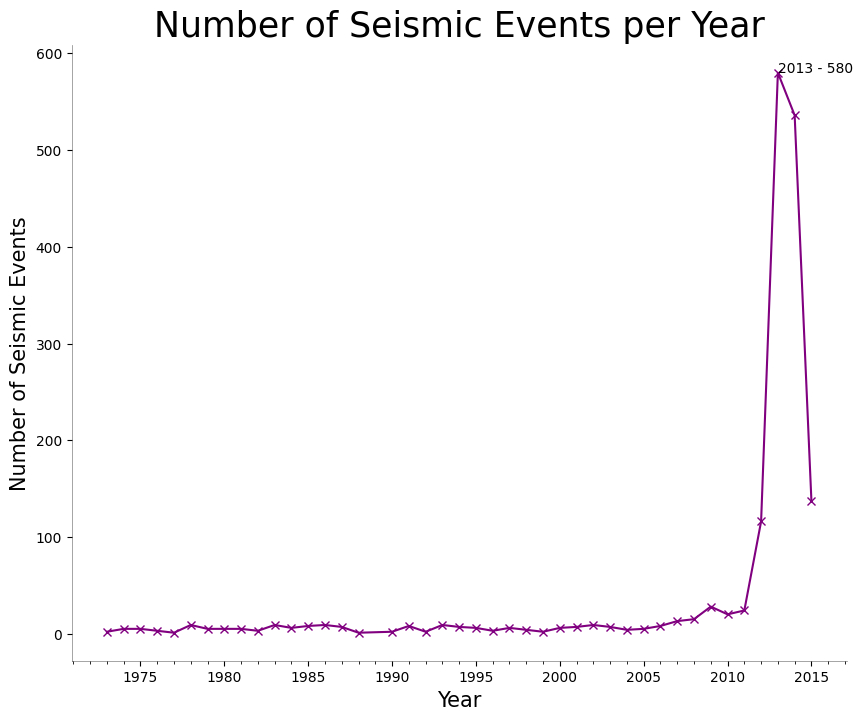

In [275]:
# Line chart to show Number of Seismic Events per Year

yearly_counts = earthquake_df.groupby('year').size()

plt.figure(figsize =(10,8))

yearly_counts.plot(kind= "line", 
                   marker= "x",
                   color = "purple")

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
    spine.set_alpha(0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator())

ax.set_xlabel("Year",
              fontsize = 15)
ax.set_ylabel("Number of Seismic Events",
              fontsize = 15)
ax.set_title('Number of Seismic Events per Year',
             fontsize = 25)

highest_index = yearly_counts.idxmax()
x_coord = highest_index
y_coord = yearly_counts.loc[highest_index]
plt.text(x_coord,
         y_coord,
         '2013 - 580')

plt.savefig('../plots/NumberOfSeismicEventsPerYear_AppalachianRegion.png')
plt.show()

With this plot, you canb see an increase for earthquakes in the Appalachian Basin region beginning in 2012, spiking to 580 recorded earthquakes in 2013 and beginning to decline in 2014 and 2015.

In [276]:
# Number of Earthquakes per Event Location for 2013

year_2013 = earthquake_df['year'] == 2013

location_counts = earthquake_df[year_2013].groupby('state').size().sort_values(ascending=False)

location_counts

state
West Virginia    454
Pennsylvania      57
New York          51
Virginia           6
Ohio               5
Quebec             5
Kentucky           1
New Jersey         1
dtype: int64

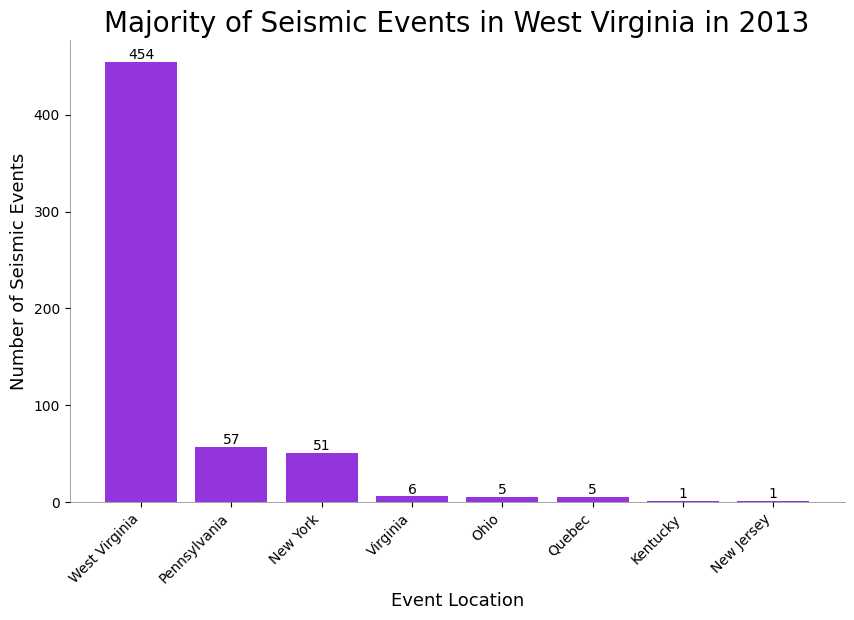

In [277]:
# Bar plot to show instances of earthquakes per Event Location

plt.figure(figsize=(10,6))

bars = plt.bar(location_counts.index,
        location_counts.values,
        width=0.8,
        color = "#9335dc")

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
    spine.set_alpha(0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Event Location',
              fontsize= 13)
ax.set_ylabel('Number of Seismic Events',
              fontsize=13)
ax.set_title('Majority of Seismic Events in West Virginia in 2013',
             fontsize = 20)
ax.bar_label(bars)
plt.xticks(rotation=45, ha="right")

plt.savefig("../plots/NumberOfSeismicEventsPerEventLocation_AppalachianRegion.png")
plt.show()

454 earthquakes occured in the West Virginia region of the Appalacian Basin for the year 2013.

In [278]:

earthquakes_2013 = earthquake_df[earthquake_df['year'] == 2013]
nat_earthquake = earthquakes_2013['potential_blast'].value_counts()

print(nat_earthquake)


potential_blast
1    460
0    120
Name: count, dtype: int64


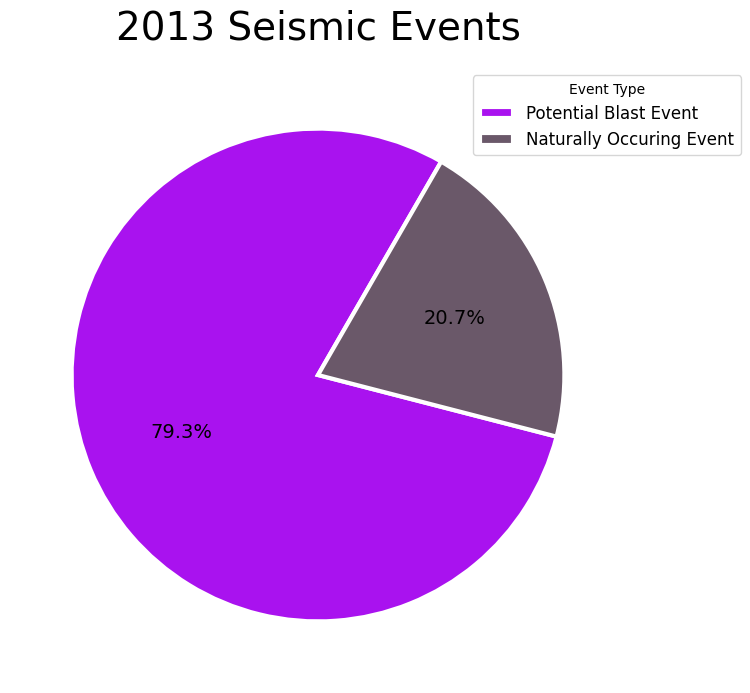

In [279]:
# Natural earthquakes vs potential blast seismic activity for 2013
plt.figure(figsize=(10,8))

earthquakes_2013 = earthquake_df[earthquake_df['year'] == 2013]
nat_earthquake = earthquakes_2013['potential_blast'].value_counts()


plt.pie(nat_earthquake,
        labels=None,
        startangle= 60,
        colors = ["#a912ef", "#6A5869"],
        autopct="%1.1f%%",
        textprops={'fontsize': 14},
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })

ax = plt.gca()
ax.set_title("2013 Seismic Events",
        fontsize = 28,
        pad = 20)  
ax.legend(
    labels = ["Potential Blast Event",'Naturally Occuring Event'],
    loc="upper right",
    title = "Event Type",
    fontsize = 12,
    bbox_to_anchor=(0.7, 0, 0.5, 1)
)

plt.savefig('../plots/2013SeismicEvents_AppalachianRegion.png')
plt.show()

What happened in 2013?

79.3% of seismic events that occured in 2013 were due to potential blasts (man-made activity).  This specific occurence was caused by a byproduct of fracking.  The wastewater from the oil and gas recovery was being disposed of deep into the Earth.  When the high-pressure wastewater was injected into the deep reservoirs, it seeped into the fault lines.  The extra fluid in the faults then acted as a lubricant, reducing friction and allowing the faults to slip, causing the earthquakes.

### Setup for SQL tables
-----
Numbers used for these tables as they will be combined with the Ok_Region_Earthquakes tables.

In [280]:
# Events2 SQL table

events2 = ['event_id', 'date', 'time']
events2_df = earthquake_df[events2].copy()
events2_df.to_csv('../data/events2.csv', index=False)

In [281]:
# Event_locations2 SQL table

event_locations2 = ['event_id', 'state', 'latitude', 'longitude']
event_locations2_df = earthquake_df[event_locations2].copy()
event_locations2_df.to_csv('../data/event_locations2.csv', index=False)

In [282]:
# Magnitude2 SQL table

magnitude2 = ['event_id', 'magnitude', 'mag_type', 'depth']
magnitude2_df = earthquake_df[magnitude2].copy()
magnitude2_df.to_csv('../data/magnitude2.csv', index=False)